In [1]:
import cv2
import numpy as np
import glob
import seaborn as sns
from sklearn.ensemble import IsolationForest
from matplotlib import pyplot as plt

Questa funzione prende in ingresso l'immagine originale, l'immagine ritagliata e il nome del salvataggio. Restituisce un immagine che rappresenta la zona di lavoro

In [2]:
def cutWorkSpace(img,border): 
    # dimensioni immagini
    img_h = 2048
    img_l = 2048
    # offset per posizionamento su area d'indagine
    offset_x = 600
    offset_y = 500
    
    #taglio per garantire la ricerca sull'area di interesse, evitando rumori dati dallo sfondo
    crop_img = img[offset_y:img_h-offset_y, offset_x:img_l-offset_x]
    
    # Convert the img to grayscale
    gray = cv2.cvtColor(crop_img,cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (9, 9), 0)
    high_thresh, thresh_im = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    #cv2.imwrite('provaT.jpg', thresh_im)
    lowThresh = 0.5*high_thresh
    
    
    # Apply edge detection method on the image
    #edges = cv2.Canny(blurred,20,150,apertureSize = 3)
    edges = cv2.Canny(blurred,20,150,apertureSize = 3)
    cv2.imwrite('canny.jpg', edges)
    # This returns an array of r and theta values
    lines = cv2.HoughLines(edges,1,np.pi/180, 100)
    #cv2.imwrite('Risultati/resFS'+name+'c.jpg', edges)
    # The below for loop runs till r and theta values 
    # are in the range of the 2d array
    i = 0
    x_first = 0
    x_second = 0
    count = 0
    delta = 30

    while count < 2:
        for r,theta in lines[i]:
            # Stores the value of cos(theta) in a
            a = np.cos(theta)

            # Stores the value of sin(theta) in b
            b = np.sin(theta)

            # x0 stores the value rcos(theta)
            x0 = a*r

            # y0 stores the value rsin(theta)
            y0 = b*r

            #ti define line lenght
            const = 3000
            # x1 stores the rounded off value of (rcos(theta)-1000sin(theta))
            x1 = int(x0 + const*(-b))

            # y1 stores the rounded off value of (rsin(theta)+1000cos(theta))
            y1 = int(y0 + const*(a))

            # x2 stores the rounded off value of (rcos(theta)+1000sin(theta))
            x2 = int(x0 - const*(-b))

            # y2 stores the rounded off value of (rsin(theta)-1000cos(theta))
            y2 = int(y0 - const*(a))

            if count == 0 :
                
                x_first = x0
                #cv2.line(img,(x1+offset_x,y1+offset_y), (x2+offset_x,y2+offset_y), (0,0,255),2)
                count += 1
            else:
                if abs(x_first-x0) > delta :
                    x_second = x0
                    #cv2.line(img,(x1+offset_x,y1+offset_y), (x2+offset_x,y2+offset_y), (0,0,255),2)
                    count += 1
            i += 1
    # All the changes made in the input image are finally
    # written on a new image houghlines.jpg
    #cv2.imwrite('Risultati/res'+name+'.jpg', img)
    scale_percent = 30 # percent of original size

  
    if x_first < x_second:
        median = (x_second+x_first)//2
        temp = img[0:img_h-1, int(offset_x+median-border):int(offset_x+median+border)]
        width = int(temp.shape[1] * scale_percent / 100)
        height = int(temp.shape[0] * scale_percent / 100)
        dim = (width, height)
        temp = cv2.resize(temp, dim, interpolation = cv2.INTER_AREA)        
        gray = cv2.cvtColor(temp,cv2.COLOR_BGR2GRAY)
        return  gray
    else:
        median = (x_first+x_second)//2.
        temp = img[0:img_h-1, int(offset_x+median-border):int(offset_x+median+border)]        
        #blurred = cv2.GaussianBlur(temp, (3,3), 0)
        width = int(temp.shape[1] * scale_percent / 100)
        height = int(temp.shape[0] * scale_percent / 100)
        dim = (width, height)
        temp = cv2.resize(temp, dim, interpolation = cv2.INTER_AREA)
        gray = cv2.cvtColor(temp,cv2.COLOR_BGR2GRAY)
        return  gray

In [3]:
def divideImage(img,pcs):
    results = []
    lung = len(img) // pcs
    for i in range(pcs):
        results.append(img[(lung*i):(lung*(i+1)-1)][:])

    return results

## Creazione histogramma usando features - creazione NN
accetta in ingresso un vettore con [[img],[classe]]
in uscita mi ritorna kmeans e MLP

In [4]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.neural_network import MLPClassifier

def createNN(imgsWithClass, Nclusters):
    
    # creo histogramma con valori trovati di feature per ogni immagine di train
    train_imgs = imgsWithClass[0]
    res = []
    k = 0
    for img in train_imgs:
        im = []
        for d in img:
            for i in d:
                im.append(i)
        im.append(imgsWithClass[1][k])
        k += 1
        res.append(im)
    
    res = np.array(res)
    
    return res
    #return kmeans, mlp, val_result

Creo funzione per testare immagini sulla NN trovata

In [5]:
def testNN(train_imgs):
    
    results=[]
    
    res = []
    for img in train_imgs:
        im = []
        for d in img:
            for i in d:
                im.append(i)
        res.append(im)
    
    res = np.array(res)
    
    cols = []
        
    for i in range(len(res[0])):
        cols.append('F'+str(i+1))


    df = pd.DataFrame(res ,columns = cols)
    results.append(model.predict(df[cols]))

    return results

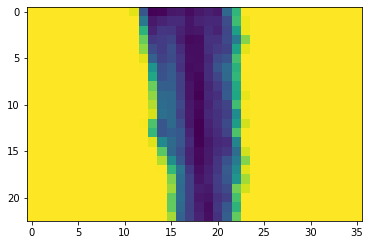

In [6]:
scelta = 120
threshold = 5
if scelta == 70:
    pathBuoni = '/Users/leonardoaggio/Desktop/Dataset/S606C/Buoni70/*.tif'
    pathBuoniVal = '/Users/leonardoaggio/Desktop/Dataset/S606C/Buoni70Val/*.tif'
    contamination_N = 6/79.

if scelta == 100:
    pathBuoni = '/Users/leonardoaggio/Desktop/Dataset/S606C/Buoni100/*.tif'
    pathBuoniVal = '/Users/leonardoaggio/Desktop/Dataset/S606C/Buoni100Val/*.tif'
    contamination_N = 6/107.
if scelta == 120:
    pathBuoni = '/Users/leonardoaggio/Desktop/Dataset/S606C/Buoni120/*.tif'
    pathBuoniVal = '/Users/leonardoaggio/Desktop/Dataset/S606C/Buoni120Val/*.tif'
    contamination_N = 6/126.

pathFS = '/Users/leonardoaggio/Desktop/Dataset/S606C/FalsiScarti/*.tif'
pathScarti = '/Users/leonardoaggio/Desktop/Dataset/S606C/Scarti/*.tif'

pathFSVal = '/Users/leonardoaggio/Desktop/Dataset/S606C/FalsiScartiVal/*.tif'
pathScartiVal = '/Users/leonardoaggio/Desktop/Dataset/S606C/ScartiVal/*.tif'

pezziXimmagine = 25
border = 60
Nclusters = 10

#
#


results = []
img_results = []
list_paths = []

list_paths += glob.glob(pathScarti)
results += [1] * len(glob.glob(pathScarti)) * pezziXimmagine

list_paths += glob.glob(pathBuoni) 
results += [0] * len(glob.glob(pathBuoni)) * pezziXimmagine

#list_paths += glob.glob(pathFS)
#results += [0] * len(glob.glob(pathFS)) * pezziXimmagine


#list_paths += glob.glob(pathBuoniVal) 
#results += [0] * len(glob.glob(pathBuoniVal)) * pezziXimmagine

#list_paths += glob.glob(pathFSVal)
#results += [0] * len(glob.glob(pathFSVal)) * pezziXimmagine

#list_paths += glob.glob(pathScartiVal)
#results += [1] * len(glob.glob(pathScartiVal)) * pezziXimmagine



#print(results)
i = 0
for img_path in list_paths:
    img = cv2.imread(img_path)
    temp = cutWorkSpace(img,border)
    #cv2.imwrite('ImgScarte/img'+str(i)+'.jpg', temp)
    temp2 = divideImage(temp,pezziXimmagine)
    img_results += temp2
    j = 0
    for im in temp2:
        #cv2.imwrite('ImgScarte/img'+str(i)+'pzs'+str(j)+'.jpg', im)
        j += 1
    i += 1
    
plt.imshow(img_results[0])
plt.show()

In [7]:
train_images = np.array(img_results)
train_images = train_images/255.

In [8]:
len(train_images)

3125

In [9]:
imgsWithClass = [train_images,results]


histo = createNN(imgsWithClass, Nclusters)

In [10]:
import pandas as pd

print(Nclusters)
cols = []
hist_2 = []
i = 0




for i in range(len(histo[0])-1):
    cols.append('F'+str(i+1))

cols.append('R')

df = pd.DataFrame(histo ,columns = cols)



10


In [11]:
#sns.boxplot(histo[0])

In [12]:
random_state = np.random.RandomState(42)

In [13]:
col = []

for i in range(len(histo[0])-1):
    col.append('F'+str(i+1))

model=IsolationForest(n_estimators=100,max_samples='auto',contamination=contamination_N,random_state=random_state)

model.fit(df[col])

print(model.get_params())

{'bootstrap': False, 'contamination': 0.047619047619047616, 'max_features': 1.0, 'max_samples': 'auto', 'n_estimators': 100, 'n_jobs': None, 'random_state': RandomState(MT19937) at 0x7F841FC30270, 'verbose': 0, 'warm_start': False}


In [14]:
df['scores'] = model.decision_function(df[col])

df['anomaly_score'] = model.predict(df[col])

#df[df['anomaly_score']==-1]

In [15]:
#threshold = 4

In [16]:
#temp = '/Users/leonardoaggio/Desktop/Dataset/S606C/Cam3@00004/*.tif'
temp = pathScarti
test_path = glob.glob(temp) 
results = []
i = 0
res = []
img_results = []
for img_path in test_path:
    img = cv2.imread(img_path)
    temp = cutWorkSpace(img,border)
    temp2 = divideImage(temp,pezziXimmagine)
    img_results = temp2
    train_images = np.array(img_results)
    train_images = train_images/255.
    res = testNN(train_images)
    scarto = 0
    for el in res:
        for e in el:
            if e == -1:
                scarto += 1
    if scarto < threshold:
        i +=1
        print(img_path)

print('TRAIN scarti')
print('BUONI : '+ str(i))
print('Falsi buoni su scarti totali: '+ str(i/len(test_path)))

/Users/leonardoaggio/Desktop/Dataset/S606C/Scarti/Cam3@00004 2.tif
TRAIN scarti
BUONI : 1
Falsi buoni su scarti totali: 0.16666666666666666


In [17]:
temp = pathScartiVal
test_path = glob.glob(temp) 
results = []
i = 0
res = []

for img_path in test_path:
    img = cv2.imread(img_path)
    temp = cutWorkSpace(img,border)
    temp2 = divideImage(temp,pezziXimmagine)
    img_results = temp2
    train_images = np.array(img_results)
    train_images = train_images/255.
    res = testNN(train_images)
    scarto = 0
    for el in res:
        for e in el:
            if e == -1:
                scarto += 1
    if scarto < threshold:
        i +=1
    print(scarto)
print('Test scarti')
print('BUONI : '+ str(i))
print('Falsi buoni su scarti totali: '+ str(i/len(test_path)))

18
12
7
Test scarti
BUONI : 0
Falsi buoni su scarti totali: 0.0


In [18]:
#temp = '/Users/leonardoaggio/Desktop/Dataset/S606C/ScartiTotali/*.tif'
#temp = '/Users/leonardoaggio/Desktop/Dataset/S606C/Cam3@00004/*.tif'


temp = pathBuoniVal
test_path = glob.glob(temp) 
results = []
i = 0
res = []

for img_path in test_path:
    img = cv2.imread(img_path)
    temp = cutWorkSpace(img,border)
    temp2 = divideImage(temp,pezziXimmagine)
    img_results = temp2
    train_images = np.array(img_results)
    train_images = train_images/255.
    res = testNN(train_images)
    scarto = 0
    for el in res:
        for e in el:
            if e == -1:
                scarto += 1
    if scarto > threshold:
        i +=1
    #print(scarto)
print('Test')
print('Scarti : '+ str(i))
print('Falsi scarti su buoni totali: '+ str(i/len(test_path)))

Test
Scarti : 2
Falsi scarti su buoni totali: 0.02531645569620253


In [19]:
#temp = '/Users/leonardoaggio/Desktop/Dataset/S606C/ScartiTotali/*.tif'
temp = '/Users/leonardoaggio/Desktop/Dataset/S606C/Cam3@00004/*.tif'


#temp = pathBuoniVal
test_path = glob.glob(temp) 
results = []
i = 0
res = []

for img_path in test_path:
    img = cv2.imread(img_path)
    temp = cutWorkSpace(img,border)
    temp2 = divideImage(temp,pezziXimmagine)
    img_results = temp2
    train_images = np.array(img_results)
    train_images = train_images/255.
    res = testNN(train_images)
    scarto = 0
    for el in res:
        for e in el:
            if e == -1:
                scarto += 1
    if scarto > threshold:
        i +=1
print('Test')
print('Scarti : '+ str(i))
print('Falsi scarti su buoni totali: '+ str(i/len(test_path)))

Test
Scarti : 5
Falsi scarti su buoni totali: 0.011467889908256881
